C:\Users\GHOST\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\GHOST\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\GHOST\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


1/1 [==============================] - 4s 4s/step


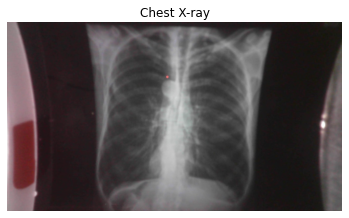

Cardiomegaly: Absent
Emphysema: Absent
Effusion: Absent
Hernia: Present
Infiltration: Absent
Mass: Absent
Nodule: Absent
Atelectasis: Absent
Pneumothorax: Absent
Pleural_Thickening: Present
Pneumonia: Absent
Fibrosis: Absent
Edema: Absent
Consolidation: Absent


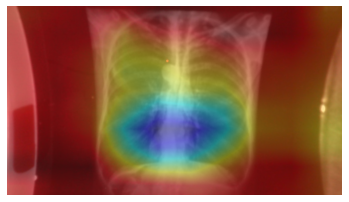

In [1]:
import keras
from keras.models import load_model, Model
from keras.utils import load_img, img_to_array
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

# Define the weighted loss function
def get_weighted_loss():
    def weighted_loss(y_true, y_pred):
        return keras.losses.binary_crossentropy(y_true, y_pred)
    return weighted_loss

# Load the trained model
model = load_model('D:/densenet121_model.h5', custom_objects={'weighted_loss': get_weighted_loss()})

# Define the labels for the diseases
labels = ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis',
          'Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']

# Function to preprocess the image
def preprocess_image(img_path, target_size=(320, 320)):
    img = load_img(img_path, target_size=target_size, color_mode='rgb')
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Normalize to [0, 1] range
    return img

# Function to generate Grad-CAM heatmap
def generate_grad_cam(model, img, layer_name, cls=-1):
    grad_model = Model(inputs=[model.inputs], outputs=[model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img)
        if cls == -1:
            cls = np.argmax(predictions[0])
        loss = predictions[:, cls]
    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]
    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')
    guided_grads = gate_f * gate_r * grads
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = np.zeros(output.shape[0:2], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * output[:, :, i]
    cam = cv2.resize(cam.numpy(), (img.shape[2], img.shape[1]))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())
    return heatmap

# Function to predict and visualize the results
def predict_and_visualize(img_path):
    preprocessed_img = preprocess_image(img_path)
    predictions = model.predict(preprocessed_img)[0]
    # Determine the presence or absence of each disease
    results = {label: 'Present' if predictions[i] > 0.5 else 'Absent' for i, label in enumerate(labels)}

    # Display the image
    img = cv2.imread(img_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Chest X-ray")
    plt.axis('off')
    plt.show()

    # Print the results
    for label, result in results.items():
        print(f"{label}: {result}")

    if all(result == 'Absent' for result in results.values()):
        print("Normal")
        return  # Exit the function if the image is classified as Normal

    # Generate and display Grad-CAM for the most likely condition
    most_likely_label_idx = np.argmax(predictions)
    heatmap = generate_grad_cam(model, preprocessed_img, layer_name='conv5_block16_concat', cls=most_likely_label_idx)

    # Resize the heatmap to match the original image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

    # Superimpose the heatmap on the original image
    img_with_heatmap = cv2.addWeighted(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), 0.6, heatmap, 0.4, 0)

    plt.imshow(img_with_heatmap)
    #plt.title(f"Grad-CAM for {labels[most_likely_label_idx]}")
    plt.axis('off')
    plt.show()

# Main function to run the application
def main(img_path):
    predict_and_visualize(img_path)

if __name__ == "__main__":
    # Replace with the path to your image
    img_path = "D:/WhatsApp Image 2024-05-31 at 3.08.48 AM.jpeg"
    main(img_path)
